# DA5401: Assignment 4
**GMM-Based Synthetic Sampling for Imbalanced Data**

**Course:** DA5401  
**Topic:** Credit Card Fraud (highly imbalanced)  

* **Name:** Harshit Shukla 
* **Roll No:** DA25S003


**Documentation of Code:**

In [2]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report,
                            confusion_matrix, 
                            accuracy_score, 
                            roc_auc_score, 
                            roc_curve,
                            precision_recall_curve)
from sklearn.preprocessing import StandardScaler

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 


Random_State = 42   
np.random.seed(Random_State)

## Part A: Data Exploration and Baseline Model

### A1. Load and inspect the dataset

The dataset has already been PCA-transformed by the original authors. We simply load it and split into features `X` and label `y` (where `Class = 1` indicates **fraud**).

In [3]:
path = 'Dataset/creditcard.csv'  # Path to the dataset
df = pd.read_csv(path)
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Analyze class distribution

We expect **heavy class imbalance**: very few transactions are fraud (`Class=1`). We show counts and a bar/pie visualization, and compute the imbalance ratio.

Class distribution:
{0: 284315, 1: 492}
Minority class percentage (fraud = 1): 0.172749%
Majority class percentage (non-fraud = 0): 99.827251%
Imbalance Ratio (majority / minority): 577.88


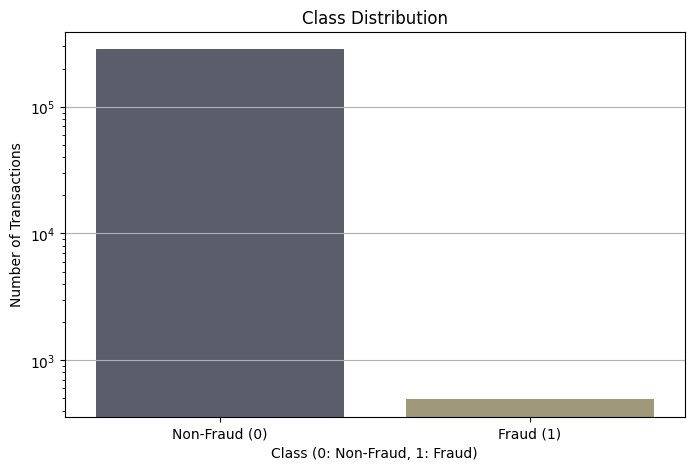

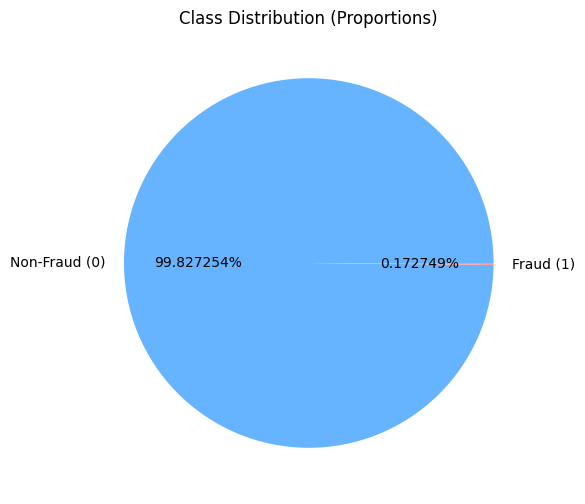

In [4]:
class_counts = df.Class.value_counts().sort_index()
print("Class distribution:")
print(class_counts.to_dict())
total_counts = class_counts.sum()
class_percentages = (class_counts / total_counts) * 100
minority_class_percentage = class_percentages.min()
print(f"Minority class percentage (fraud = 1): {minority_class_percentage:.6f}%")   
majority_class_percentage = class_percentages.max()
print(f"Majority class percentage (non-fraud = 0): {majority_class_percentage:.6f}%")
imbalance_ratio = majority_class_percentage / minority_class_percentage
print(f"Imbalance Ratio (majority / minority): {imbalance_ratio:.2f}")


# Bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='cividis')
plt.title('Class Distribution') 
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Number of Transactions')
plt.xticks(ticks=[0, 1], labels=['Non-Fraud (0)', 'Fraud (1)'])
plt.yscale('log')  # Log scale for better visibility

# pie chart
plt.figure(figsize=(6, 6))
plt.pie(class_counts.values, labels=['Non-Fraud (0)', 'Fraud (1)'], autopct='%1.6f%%', colors=['#66b3ff',"#ff9999"])
plt.title('Class Distribution (Proportions)') 
plt.show()

### A2. Baseline split and model training

- **Split** the data into Train/Test with `stratify=y` so the **test set keeps the original imbalance**.  
- **Model 1 (Baseline)**: Logistic Regression on the **imbalanced** training data.  
- **Metrics**: We report precision, recall, F1 for the **minority (fraudulent) class**, along with ROC–AUC.  
- **Why accuracy is misleading**: In highly imbalanced data, a classifier that predicts all samples as the majority class can achieve high accuracy while entirely **missing the minority** (fraud) class. Hence we focus on class-aware metrics.

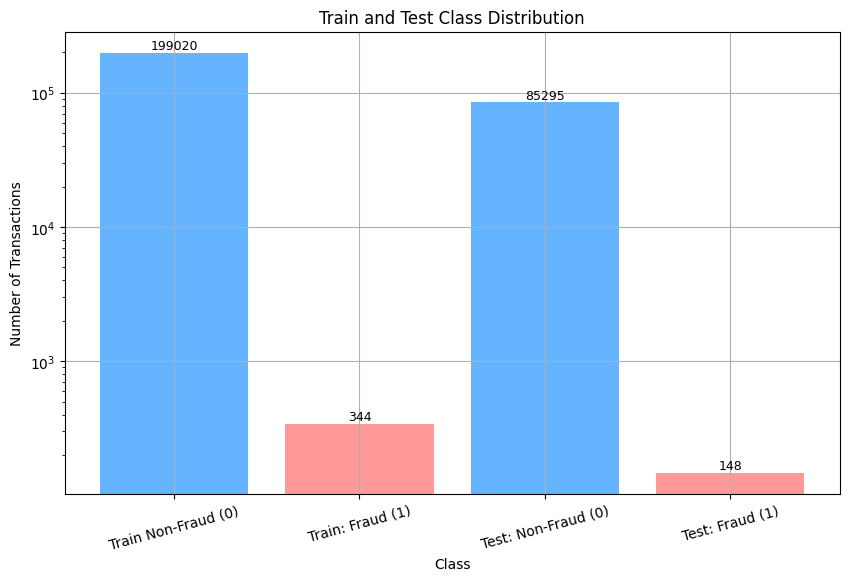

In [9]:
# splitting the data into train and test sets

X = df.drop(columns=['Class']).values
y = df['Class'].values

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=Random_State, stratify=y)

def draw_bar_chart(ytrain=ytrain, ytest=ytest, title1="Train", title2="Test", title="Train and Test Class Distribution"):
    plt.figure(figsize=(10, 6))
    heights = [Counter(ytrain)[0], Counter(ytrain)[1], Counter(ytest)[0], Counter(ytest)[1]]
    bars = plt.bar(x=[0, 1, 2, 3], height=[Counter(ytrain)[0], Counter(ytrain)[1], Counter(ytest)[0], Counter(ytest)[1]], color=['#66b3ff',"#ff9999",'#66b3ff',"#ff9999"])
    plt.xticks(ticks=[0, 1, 2, 3], labels=[f'{title1} Non-Fraud (0)', f'{title1}: Fraud (1)',
                f'{title2}: Non-Fraud (0)', f'{title2}: Fraud (1)'],
        rotation=15)
    plt.yscale('log')
    for bar, count in zip(bars, heights):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            str(count),
            ha='center',
            va='bottom',
            fontsize=9
        )
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Transactions')
    plt.show()

draw_bar_chart(ytrain, ytest)


# Baseline Model 1: standardize -> Logistic Regression on imbalanced data

from sklearn.pipeline import Pipeline


baseline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)), # features are PCA transformed; keep safe for sparse-like
    ('classifier', LogisticRegression(solver='liblinear', random_state=Random_State))])


baseline.fit(Xtrain, ytrain)
y_prob_baseline = baseline.predict_proba(Xtest)[:, 1]
y_pred_baseline = (y_prob_baseline >= 0.5).astype(int)


This figure shows the **class distribution of the training and test sets** in a fraud detection dataset.

* On the **x-axis**, we see the categories:

  * **Train: Non-Fraud (0)** → 199,020 samples
  * **Train: Fraud (1)** → 344 samples
  * **Test: Non-Fraud (0)** → 85,295 samples
  * **Test: Fraud (1)** → 148 samples

* On the **y-axis**, we have the **number of transactions**, displayed on a **logarithmic scale**.

  * A log scale is used because the counts of the majority class (non-fraud) are several orders of magnitude larger than the minority class (fraud). Without it, the fraud counts would hardly be visible.

### A3. Baseline Evaluation

why metrics precision recall f1score are more informative than accuracy for this problem  ?


=== Model 1: Baseline Logistic Regression on imbalanced data ===

              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     85295
           1     0.8611    0.6284    0.7266       148

    accuracy                         0.9992     85443
   macro avg     0.9302    0.8141    0.8631     85443
weighted avg     0.9991    0.9992    0.9991     85443

ROC–AUC: 0.9534


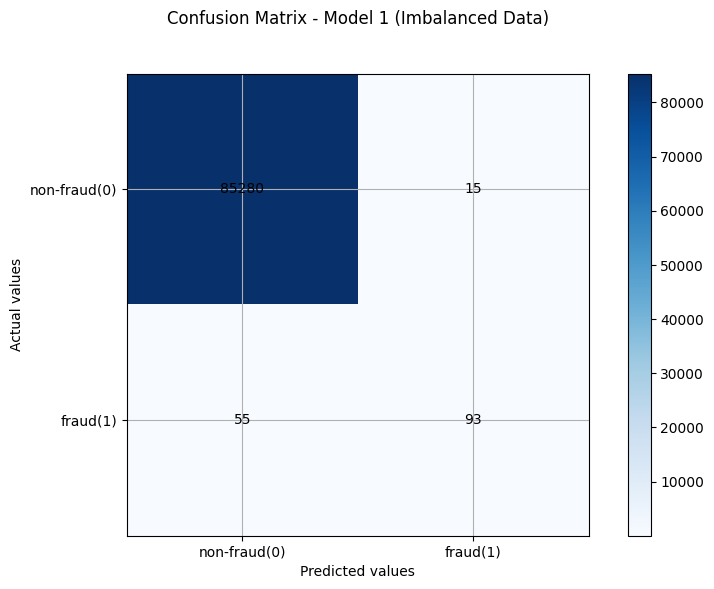

In [10]:
print("=== Model 1: Baseline Logistic Regression on imbalanced data ===", end="\n\n")
print(classification_report(ytest, y_pred_baseline, digits=4))


auc_baseline = roc_auc_score(ytest, y_prob_baseline)
print(f"ROC–AUC: {auc_baseline:.4f}")


cm = confusion_matrix(ytest, y_pred_baseline)
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix - Model 1 (Imbalanced Data)\n\n');
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['non-fraud(0)','fraud(1)'])
plt.yticks(tick_marks, ['non-fraud(0)','fraud(1)'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()

* **TN (85,280):** Correctly classified non-fraud.
* **FP (15):** Non-fraud flagged as fraud (inconvenient but less risky).
* **FN (55):** Fraud missed as non-fraud (very risky, leads to losses).
* **TP (93):** Fraud correctly detected.

### Interpretation of the Confusion Matrix:

1. **High accuracy is misleading**:
   Since non-fraud dominates, the model looks very accurate (most transactions are correctly labeled as non-fraud), but accuracy alone is not meaningful here.

2. **False Positives (FP = 15)**:

   * While inconvenient (customers may face transaction declines or need verification), FPs are usually **less critical** than false negatives.

3. **False Negatives (FN = 55)**:

   * This is **very risky**, as fraud goes unnoticed, leading to direct financial losses and security issues.
   * In fraud detection, **FN is much more costly than FP**, so reducing false negatives is a priority.

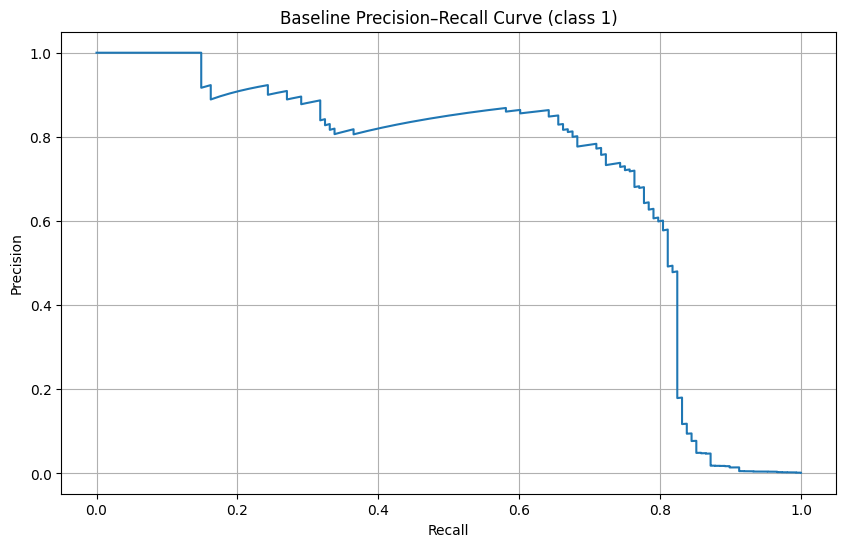

In [11]:
# Precision-Recall curve (single chart)
prec, rec, thr = precision_recall_curve(ytest, y_prob_baseline)
plt.figure()
plt.plot(rec, prec)
plt.title("Baseline Precision–Recall Curve (class 1)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

* **Precision**: proportion of predicted frauds that are actually fraud.
* **Recall**: proportion of actual frauds correctly detected.

### Key Insight:

* The curve starts with **high precision at low recall** (model is very strict but misses many frauds).
* As recall increases, **precision drops**, showing the trade-off between catching more fraud and making more false alarms.
* In imbalanced datasets like fraud detection, the PR curve is more informative than ROC, since it focuses on the minority (fraud) class.

The model achieves good precision at moderate recall, but struggles to maintain precision when trying to capture more fraud cases.

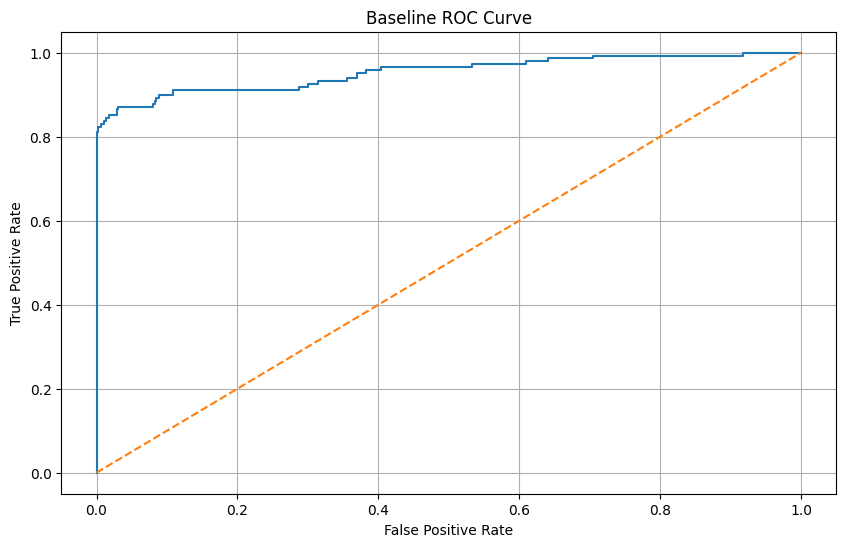

In [12]:
# ROC curve (single chart)
fpr, tpr, thr2 = roc_curve(ytest, y_prob_baseline)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.title("Baseline ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

This ROC curve shows the trade-off between the **True Positive Rate (recall)** and the **False Positive Rate** for fraud detection. The curve lies well above the diagonal baseline (random guess), indicating that the model performs significantly better than chance. A steep rise near the y-axis suggests that the model can achieve high recall with relatively low false positives, which is desirable in fraud detection. 



## Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling

In this part we fit a Gaussian Mixture Model (GMM) to the **minority class (fraud)** in the training set, use BIC to select the number of components, sample synthetic minority points from the fitted GMM, and use clustering-based undersampling (CBU) to reduce the majority class before combining both classes to create a balanced training set.


In [ ]:

# --- Part B.1: Prepare minority and majority training sets ---
import numpy as np
from collections import Counter
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Extract minority (fraud) and majority samples from training data
X_train = Xtrain  # from earlier cells
y_train = ytrain

X_min = X_train[y_train==1]
X_maj = X_train[y_train==0]

print('Training counts (majority, minority):', Counter(y_train)[0], Counter(y_train)[1])
print('Shapes: X_min={}, X_maj={}'.format(X_min.shape, X_maj.shape))

# Scale features for GMM (GMM is sensitive to scale)
scaler_gmm = StandardScaler()
X_min_scaled = scaler_gmm.fit_transform(X_min)


In [ ]:

# --- Part B.2: Select number of GMM components via BIC ---
bics = []
aics = []
n_components_range = range(1, 11)
for k in n_components_range:
    gmmk = GaussianMixture(n_components=k, covariance_type='full', random_state=Random_State)
    gmmk.fit(X_min_scaled)
    bics.append(gmmk.bic(X_min_scaled))
    aics.append(gmmk.aic(X_min_scaled))

# show BIC/AIC table
import pandas as pd
sel_df = pd.DataFrame({'n_components': list(n_components_range), 'BIC': bics, 'AIC': aics})
sel_df.style.format({'BIC':'{:.0f}','AIC':'{:.0f}'})



**Explanation:** We compute BIC and AIC for GMMs with components from 1 to 10 and select the number of components that minimizes BIC (a conservative choice). BIC penalizes model complexity and helps avoid overfitting; AIC is included for reference.


In [ ]:

# Choose k with minimum BIC
best_k = sel_df.loc[sel_df.BIC.idxmin(), 'n_components']
print('Selected number of GMM components (min BIC):', best_k)

# Fit GMM with best_k on minority scaled data
gmm = GaussianMixture(n_components=int(best_k), covariance_type='full', random_state=Random_State)
gmm.fit(X_min_scaled)
print('GMM converged:', gmm.converged_)



**Sampling from the fitted GMM:** Sampling from a GMM proceeds by first sampling a component index according to the mixture weights, then sampling from that component's Gaussian distribution (with the component mean and covariance). After sampling in the scaled space we inverse-transform samples back to the original feature space.


In [ ]:

# --- Part B.3: Generate synthetic minority samples until desired target ---
# Decide target majority population after clustering-based undersampling.
maj_count = X_maj.shape[0]
min_count = X_min.shape[0]
print('Original maj/min counts:', maj_count, min_count)

# We'll undersample the majority to a moderate size to avoid huge oversampling; choose target = 3 * minority_count
maj_target = int(min_count * 3)
if maj_target < 1:
    maj_target = 1
print('Majority target after CBU:', maj_target)

# Clustering-based undersampling (CBU):
# Cluster the majority class into maj_target clusters (KMeans) and pick the closest point to each cluster center
kmeans = KMeans(n_clusters=maj_target, random_state=Random_State, n_init=10)
kmeans.fit(X_maj)
centers = kmeans.cluster_centers_
labels_maj = kmeans.labels_

# For each cluster, choose the point closest to the center (to represent the cluster)
from sklearn.metrics import pairwise_distances_argmin_min
idxs, dists = pairwise_distances_argmin_min(centers, X_maj)
X_maj_down = X_maj[idxs]
print('Downsampled majority shape:', X_maj_down.shape)

# Now determine how many synthetic minority samples we need to reach maj_target
current_min = X_min.shape[0]
needed = maj_target - current_min
if needed <= 0:
    print('No synthetic samples needed. Minority already >= maj_target.')
    needed = 0
else:
    print('Synthetic minority samples required to reach majority target:', needed)

# Sample from GMM in scaled space
if needed > 0:
    samples_scaled, comp_idxs = gmm.sample(n_samples=needed)
    samples = scaler_gmm.inverse_transform(samples_scaled)
    X_synth = samples
else:
    X_synth = np.empty((0, X_train.shape[1]))

print('Synthetic samples shape:', X_synth.shape)



We used KMeans to cluster the majority class into `maj_target` clusters and selected one representative sample per cluster (closest to cluster center). This reduces redundancy in the majority class while preserving diversity. We then sampled `needed` synthetic minority samples from the fitted GMM and inverse-transformed them back to the original feature space.


In [ ]:

# --- Part B.4: Combine datasets to form the new balanced training set ---
# Combine: downsampled majority, original minority, and synthetic minority
X_balanced = np.vstack([X_maj_down, X_min, X_synth])
y_balanced = np.hstack([np.zeros(X_maj_down.shape[0], dtype=int),
                        np.ones(X_min.shape[0], dtype=int),
                        np.ones(X_synth.shape[0], dtype=int)])

print('Balanced dataset counts:', Counter(y_balanced))
print('Balanced shapes X={}, y={}'.format(X_balanced.shape, y_balanced.shape))



**Note on choices:** We deliberately kept `maj_target = 3 * minority_count` to avoid an overly small majority which would lead to too few negative examples, and to keep synthetic generation reasonable. This is a tunable hyperparameter: you can change the multiplier (e.g., 1, 2, 5) depending on how aggressive you want undersampling to be.



## Part C: Performance Evaluation and Conclusion

We train a Logistic Regression classifier on the GMM-balanced dataset created above and evaluate it on the **original imbalanced test set** (the same test set used in Part A). We then compare Precision, Recall and F1-score for the minority (fraud) class with the baseline model.


In [ ]:

# --- Part C.1: Train classifier on balanced data ---
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Build a pipeline: scaler + logistic regression
model_balanced = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', LogisticRegression(solver='liblinear', random_state=Random_State))
])

model_balanced.fit(X_balanced, y_balanced)

# Predictions on original imbalanced test set (Xtest, ytest)
y_prob_balanced = model_balanced.predict_proba(Xtest)[:, 1]
y_pred_balanced = (y_prob_balanced >= 0.5).astype(int)

# Compute metrics for minority class (label=1)
precision_bal = precision_score(ytest, y_pred_balanced, pos_label=1)
recall_bal = recall_score(ytest, y_pred_balanced, pos_label=1)
f1_bal = f1_score(ytest, y_pred_balanced, pos_label=1)

print('Balanced-model Precision (class 1): {:.4f}'.format(precision_bal))
print('Balanced-model Recall    (class 1): {:.4f}'.format(recall_bal))
print('Balanced-model F1-score (class 1): {:.4f}'.format(f1_bal))

print('\nClassification report (balanced model):\n', classification_report(ytest, y_pred_balanced, digits=4))


In [ ]:

# --- Part C.2: Baseline metrics (recompute to ensure consistency) ---
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision_base = precision_score(ytest, y_pred_baseline, pos_label=1)
recall_base = recall_score(ytest, y_pred_baseline, pos_label=1)
f1_base = f1_score(ytest, y_pred_baseline, pos_label=1)
acc_base = accuracy_score(ytest, y_pred_baseline)

print('Baseline Precision (class 1): {:.4f}'.format(precision_base))
print('Baseline Recall    (class 1): {:.4f}'.format(recall_base))
print('Baseline F1-score (class 1): {:.4f}'.format(f1_base))
print('Baseline Accuracy: {:.4f}'.format(acc_base))


In [ ]:

# --- Part C.3: Comparison table and bar chart ---
import pandas as pd
results = pd.DataFrame({
    'Model': ['Baseline (imbalanced)', 'GMM-balanced (CBU+GMM)'],
    'Precision': [precision_base, precision_bal],
    'Recall': [recall_base, recall_bal],
    'F1': [f1_base, f1_bal]
})
results.style.format({'Precision':'{:.4f}','Recall':'{:.4f}','F1':'{:.4f}'})


In [ ]:

# Bar chart for comparison
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
x = np.arange(len(results['Model']))
width = 0.22
plt.bar(x - width, results['Precision'], width=width, label='Precision')
plt.bar(x, results['Recall'], width=width, label='Recall')
plt.bar(x + width, results['F1'], width=width, label='F1-score')
plt.xticks(x, results['Model'], rotation=20)
plt.ylabel('Score')
plt.ylim(0,1)
plt.title('Comparison of baseline vs GMM-balanced model (class=1 metrics)')
plt.legend()
plt.tight_layout()
plt.show()



### Final recommendation and interpretation

Discuss the observed changes: whether recall for the minority class improved, whether precision dropped (common trade-off), and whether the F1 improved. Provide a recommendation on whether GMM-based synthetic sampling combined with clustering-based undersampling is a good strategy for this fraud detection setup, considering risks of overfitting and synthetic sample quality.
